In [494]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, KFold
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, auc, f1_score, classification_report, roc_auc_score
import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline

# setup
import os
os.chdir("/Users/adesai/mcadoo-failures-master/")
import glob
import feather

In [419]:
failures = pd.read_csv("failures.csv", index_col=0)
failures.head()

,Site,ID,Distance.to.turbine.south,Distance.to.turbine.north,Distance.to.terrain.feature.south,Distance.to.terrain.feature.north,Component.Manufacturer,Oil.Grease.Type,Failure,Individual.Damaged.Components,Starting.Date,Shutdown.Date,Operating.Hours.Before.Failure,Wallclock.Minutes.Before.Failure
1,McAdoo,1,35,35,1670,750,Moventas,Castrol A 320,no,na,7/2/08,NaN,24,NaN
2,McAdoo,2,35,35,1720,1020,Winergy,Castrol A 320,yes,HSS Bearing A,7/2/08,2/20/12,11,1912380.0
3,McAdoo,3,35,35,1700,1050,Winergy,Castrol A 320,no,na,7/2/08,NaN,24,NaN
4,McAdoo,4,35,36,2450,1160,Moventas,Castrol A 320,yes,HSS Bearing A,7/2/08,2/10/12,10,1897980.0
5,McAdoo,4,35,36,2450,1160,Moventas,Castrol X 320,yes,HSS Bearing A,2/10/12,4/29/13,2,639300.0


In [420]:
Moventas_Ids = [4, 20, 23, 28, 56, 100, 14]
Winergy_Ids = [2, 29, 65, 70, 84]

## Winergy

In [642]:
def rms(data):
    rms = np.sqrt(np.sum([i**2 for i in data]))/len(data)
    return rms

def kurtosis(data):
    norm_data = data - np.mean(data)
    if sum(norm_data) == 0:
        return np.nan
    ku = np.mean(norm_data**4)/np.mean(norm_data**2)**2
    return ku


feats_1 = ['power', 'rotor_speed', 'gearbox_oil_temperature', 'gearbox_bearing_temperature', 'nacelle_temperature']
feats_2 = ['wind_speed', 'ambient_temperature', 'direction10sec.sin', 'direction10sec.cos', 'direction1sec.sin', 'direction1sec.cos']
feats_3 = ['month.sin', 'month.cos', 'failure']

agg_dict = {i:['mean', np.std, rms, kurtosis] for i in feats_1}
agg_dict.update({i:['mean', np.std] for i in feats_2})

def value(data):
    return data.value_counts().index[0]
agg_dict.update({i:[value] for i in feats_3})

In [644]:
def prep_df(turbine_ids, shutdown = 0):
    df = pd.DataFrame()

    for i in turbine_ids:
        temp_df = feather.read_dataframe(glob.glob("Datafeathers/running/*_" + str(i) + "_*.feather")[0])
        temp_df.time = pd.to_datetime(temp_df.time)
        temp_df["Date"] = temp_df.time.dt.date
        
        if shutdown == 0:
            shutdown_date = pd.to_datetime(failures['Shutdown.Date'][failures.ID == i].iloc[0])
        else:
            shutdown_date = shutdown
        temp_df = temp_df[temp_df.Date <= shutdown_date]
        temp_df['failure'] = 0
        temp_df.loc[temp_df.Date >= (shutdown_date - datetime.timedelta(days=30)), 'failure'] = 1

        df = df.append(temp_df)

    df = df.reset_index(drop = True)

    df['month'] = df.time.dt.month    
    df['hour'] = df.time.dt.hour

    df['month.sin'] = np.sin(2*np.pi*df['month']/12)
    df['month.cos'] = np.cos(2*np.pi*df['month']/12)
    df['hour.sin'] = np.sin(2*np.pi*df['hour']/24)
    df['hour.cos'] = np.cos(2*np.pi*df['hour']/24)

    df['wind_direction_10_sec'] = df['wind_direction_10_sec'].apply(lambda x: x+360 if x<0 else x)
    df['wind_direction_1_sec'] = df['wind_direction_10_sec'].apply(lambda x: x+360 if x<0 else x)
    df['direction10sec.sin'] = np.sin(2*np.pi*df['wind_direction_10_sec']/360)
    df['direction10sec.cos'] = np.cos(2*np.pi*df['wind_direction_10_sec']/360)
    df['direction1sec.sin'] = np.sin(2*np.pi*df['wind_direction_1_sec']/360)
    df['direction1sec.cos'] = np.cos(2*np.pi*df['wind_direction_1_sec']/360)

    df.drop(['month', 'hour', 'wind_direction_10_sec', 'wind_direction_1_sec', 'stateFault'], axis = 1, inplace = True)
    
    df = df.groupby(['turbine_id', 'Date']).agg(agg_dict)
    df.columns = ['_'.join(x) if isinstance(x,tuple) else x for x in df.columns.ravel()]
    df = df.reset_index()
    
    df = df.assign(**{
        '{} (t-{})'.format(col, t): df.groupby('turbine_id')[col].diff(t)
        for t in [1,15,30]
        for col in ['power_mean', 'rotor_speed_mean', 'gearbox_bearing_temperature_mean', 'gearbox_oil_temperature_mean', 'nacelle_temperature_mean']
    })
    df.dropna(inplace = True)
    
    df['power_EI'] = df.power_rms/df.groupby('turbine_id').power_rms.transform('mean')
    df['gearbox_bearing_temperature_EI'] = df.gearbox_bearing_temperature_rms/df.groupby('turbine_id').gearbox_bearing_temperature_rms.transform('mean')
    df['gearbox_oil_temperature_EI'] = df.gearbox_oil_temperature_rms/df.groupby('turbine_id').gearbox_oil_temperature_rms.transform('mean')
    df['nacelle_temperature_EI'] = df.nacelle_temperature_rms/df.groupby('turbine_id').nacelle_temperature_rms.transform('mean')

    return df

In [643]:
df_check = prep_df(Winergy_Ids)
df_check.head()

,turbine_id,Date,power_mean,power_std,power_rms,power_kurtosis,rotor_speed_mean,rotor_speed_std,rotor_speed_rms,rotor_speed_kurtosis,...,nacelle_temperature_mean (t-15),power_mean (t-30),rotor_speed_mean (t-30),gearbox_bearing_temperature_mean (t-30),gearbox_oil_temperature_mean (t-30),nacelle_temperature_mean (t-30),power_EI,gearbox_bearing_temperature_EI,gearbox_oil_temperature_EI,nacelle_temperature_EI
30,2,2008-12-31,682.790300,668.264968,201.413376,1.254915,9.919606,9.222386,2.857088,1.040994,...,-1.136523,63.723599,-5.801559,-5.317696,-3.207241,-1.713446,2.984135,2.025173,2.091830,1.328439
31,2,2009-01-01,-1.962200,1.458646,0.485501,9.974295,0.176680,0.071173,0.037989,4.835816,...,-4.742095,-632.792012,-16.231858,-26.066788,-13.630849,-14.617927,0.007193,1.175029,1.490776,1.010311
32,2,2009-01-02,513.366028,489.932043,73.007180,1.821188,11.282246,8.050484,1.426981,1.463668,...,3.266422,-970.728813,-6.881627,-6.195855,-2.281641,4.538171,1.081672,1.004287,1.022233,1.082683
33,2,2009-01-03,57.036833,78.258674,17.486636,1.870200,4.850500,5.740028,1.358639,1.199283,...,0.125572,-480.452173,-10.741827,-9.852931,-5.314653,10.293777,0.259081,1.594740,1.758372,1.777574
34,2,2009-01-04,1332.568842,465.968070,173.623424,7.376695,16.441940,5.622116,2.137212,7.564648,...,-6.808222,1094.177176,6.815510,7.417180,2.459568,-3.770868,2.572400,1.263227,1.261701,0.369968


In [421]:
# preparing dataframe
df_hssA_w = pd.DataFrame()

for i in Winergy_Ids:
    temp_df = feather.read_dataframe(glob.glob("Datafeathers/running/*_" + str(i) + "_*.feather")[0])
    temp_df.time = pd.to_datetime(temp_df.time)
    temp_df["Date"] = temp_df.time.dt.date
    
    shutdown_date = pd.to_datetime(failures['Shutdown.Date'][failures.ID == i].iloc[0])
    temp_df = temp_df[temp_df.Date <= shutdown_date]
    temp_df['failure'] = 0
    temp_df.loc[temp_df.Date >= (shutdown_date - datetime.timedelta(days=30)), 'failure'] = 1
    
    df_hssA_w = df_hssA_w.append(temp_df)

df_hssA_w = df_hssA_w.reset_index(drop = True)

df_hssA_w['month'] = df_hssA_w.time.dt.month    
df_hssA_w['hour'] = df_hssA_w.time.dt.hour

df_hssA_w['month.sin'] = np.sin(2*np.pi*df_hssA_w['month']/12)
df_hssA_w['month.cos'] = np.cos(2*np.pi*df_hssA_w['month']/12)
df_hssA_w['hour.sin'] = np.sin(2*np.pi*df_hssA_w['hour']/24)
df_hssA_w['hour.cos'] = np.cos(2*np.pi*df_hssA_w['hour']/24)

df_hssA_w['wind_direction_10_sec'] = df_hssA_w['wind_direction_10_sec'].apply(lambda x: x+360 if x<0 else x)
df_hssA_w['wind_direction_1_sec'] = df_hssA_w['wind_direction_10_sec'].apply(lambda x: x+360 if x<0 else x)
df_hssA_w['direction10sec.sin'] = np.sin(2*np.pi*df_hssA_w['wind_direction_10_sec']/360)
df_hssA_w['direction10sec.cos'] = np.cos(2*np.pi*df_hssA_w['wind_direction_10_sec']/360)
df_hssA_w['direction1sec.sin'] = np.sin(2*np.pi*df_hssA_w['wind_direction_1_sec']/360)
df_hssA_w['direction1sec.cos'] = np.cos(2*np.pi*df_hssA_w['wind_direction_1_sec']/360)

df_hssA_w.drop(['month', 'hour', 'wind_direction_10_sec', 'wind_direction_1_sec', 'stateFault'], axis = 1, inplace = True)

In [422]:
df_hssA_w.shape

(497708, 19)

In [423]:
df_hssA_w.head()

,turbine_id,time,power,rotor_speed,wind_speed,gearbox_oil_temperature,gearbox_bearing_temperature,ambient_temperature,nacelle_temperature,Date,failure,month.sin,month.cos,hour.sin,hour.cos,direction10sec.sin,direction10sec.cos,direction1sec.sin,direction1sec.cos
0,2,2008-12-01 00:00:00,707.436646,17.981501,7.613500,52.666668,60.423332,7.000000,12.318334,2008-12-01,0,-2.449294e-16,1.0,0.0,1.0,0.167342,0.985899,0.167342,0.985899
1,2,2008-12-01 00:10:00,851.526672,17.999834,8.482500,52.830002,60.488335,7.000000,12.203333,2008-12-01,0,-2.449294e-16,1.0,0.0,1.0,0.071613,0.997432,0.071613,0.997432
2,2,2008-12-01 00:20:00,675.460022,17.659000,7.816834,52.375000,60.180000,7.000000,12.120000,2008-12-01,0,-2.449294e-16,1.0,0.0,1.0,-0.009105,0.999959,-0.009105,0.999959
3,2,2008-12-01 00:30:00,639.909973,17.532167,7.568333,52.281666,60.111668,7.000000,12.186666,2008-12-01,0,-2.449294e-16,1.0,0.0,1.0,-0.055909,0.998436,-0.055909,0.998436
4,2,2008-12-01 00:40:00,630.469971,17.526833,7.442333,52.630001,60.051666,6.998333,12.610000,2008-12-01,0,-2.449294e-16,1.0,0.0,1.0,-0.219023,0.975720,-0.219023,0.975720


In [424]:
df_hssA_w.turbine_id.unique()

array([ 2, 29, 65, 70, 84])

In [425]:
df_hssA_w.failure.value_counts()

0    478479
1     19229
Name: failure, dtype: int64

In [426]:
df_hssA_w.isnull().sum()

turbine_id                     0
time                           0
power                          0
rotor_speed                    0
wind_speed                     0
gearbox_oil_temperature        0
gearbox_bearing_temperature    0
ambient_temperature            0
nacelle_temperature            0
Date                           0
failure                        0
month.sin                      0
month.cos                      0
hour.sin                       0
hour.cos                       0
direction10sec.sin             0
direction10sec.cos             0
direction1sec.sin              0
direction1sec.cos              0
dtype: int64

In [427]:
df_hssA_w.corr()['failure']

turbine_id                     0.036963
power                          0.068573
rotor_speed                    0.046136
wind_speed                     0.026592
gearbox_oil_temperature       -0.022357
gearbox_bearing_temperature   -0.004542
ambient_temperature           -0.198398
nacelle_temperature           -0.198506
failure                        1.000000
month.sin                      0.074941
month.cos                      0.246941
hour.sin                      -0.003557
hour.cos                       0.002360
direction10sec.sin            -0.002599
direction10sec.cos             0.017297
direction1sec.sin             -0.002599
direction1sec.cos              0.017297
Name: failure, dtype: float64

In [428]:
#status code
#df_hssA_w["state"] = np.nan
#df_hssA_w.state[df_hssA_w.stateFault == 2] = "running"
#df_hssA_w.state[df_hssA_w.stateFault == 3] = "startup"
#df_hssA_w.state[df_hssA_w.stateFault.isin([7, 11])] = "e_shutdown"
#df_hssA_w.state[df_hssA_w.stateFault.isin([9, 10, 12, 13, 14, 15])] = "regular_shutdown"
#df_hssA_w.state[df_hssA_w.state.isnull()] = "unknown"

In [429]:
def rms(data):
    rms = np.sqrt(np.sum([i**2 for i in data]))/len(data)
    return rms

def kurtosis(data):
    norm_data = data - np.mean(data)
    if sum(norm_data) == 0:
        return np.nan
    ku = np.mean(norm_data**4)/np.mean(norm_data**2)**2
    return ku

In [440]:
feats_1 = ['power', 'rotor_speed', 'gearbox_oil_temperature', 'gearbox_bearing_temperature', 'nacelle_temperature']
feats_2 = ['wind_speed', 'ambient_temperature', 'direction10sec.sin', 'direction10sec.cos', 'direction1sec.sin', 'direction1sec.cos']
feats_3 = ['month.sin', 'month.cos', 'failure']

agg_dict = {i:['mean', np.std, rms, kurtosis] for i in feats_1}
agg_dict.update({i:['mean', np.std] for i in feats_2})

def value(data):
    return data.value_counts().index[0]
agg_dict.update({i:[value] for i in feats_3})

In [441]:
df_agg_w = df_hssA_w.groupby(['turbine_id', 'Date']).agg(agg_dict)
df_agg_w.columns = ['_'.join(x) if isinstance(x,tuple) else x for x in df_agg_w.columns.ravel()]
df_agg_w = df_agg_w.reset_index()
df_agg_w.head()

,turbine_id,Date,power_mean,power_std,power_rms,power_kurtosis,rotor_speed_mean,rotor_speed_std,rotor_speed_rms,rotor_speed_kurtosis,...,direction10sec.sin_std,direction10sec.cos_mean,direction10sec.cos_std,direction1sec.sin_mean,direction1sec.sin_std,direction1sec.cos_mean,direction1sec.cos_std,month.sin_value,month.cos_value,failure_value
0,2,2008-12-01,619.066702,395.056823,78.602709,2.424308,15.721165,3.332425,1.722510,8.242283,...,0.117716,0.992735,0.022657,0.016479,0.117716,0.992735,0.022657,-2.449294e-16,1.0,0
1,2,2008-12-02,630.829812,378.499334,100.799160,3.537492,16.408538,2.516045,2.279735,22.850061,...,0.062181,0.998005,0.003090,-0.013495,0.062181,0.998005,0.003090,-2.449294e-16,1.0,0
2,2,2008-12-03,1484.094842,114.619552,324.774613,18.289232,18.163873,0.942526,3.968761,19.047282,...,0.070068,0.997180,0.004622,0.030580,0.070068,0.997180,0.004622,-2.449294e-16,1.0,0
3,2,2008-12-04,537.489006,329.205906,55.011703,2.264321,15.592327,2.644072,1.381609,1.523576,...,0.080349,0.996775,0.005161,-0.002522,0.080349,0.996775,0.005161,-2.449294e-16,1.0,0
4,2,2008-12-05,238.391666,346.931946,42.590294,5.723599,9.626430,6.653666,1.186188,1.727711,...,0.114482,0.992918,0.028531,0.018382,0.114482,0.992918,0.028531,-2.449294e-16,1.0,0


In [445]:
df_agg_w.failure_value.value_counts()

0    3746
1     153
Name: failure_value, dtype: int64

In [443]:
df_agg_w = df_agg_w.assign(**{
    '{} (t-{})'.format(col, t): df_agg_w.groupby('turbine_id')[col].diff(t)
    for t in [1,15,30]
    for col in ['power_mean', 'rotor_speed_mean', 'gearbox_bearing_temperature_mean', 'gearbox_oil_temperature_mean', 'nacelle_temperature_mean']
})
df_agg_w.dropna(inplace = True)

In [444]:
df_agg_w['power_EI'] = df_agg_w.power_rms/df_agg_w.groupby('turbine_id').power_rms.transform('mean')
df_agg_w['gearbox_bearing_temperature_EI'] = df_agg_w.gearbox_bearing_temperature_rms/df_agg_w.groupby('turbine_id').gearbox_bearing_temperature_rms.transform('mean')
df_agg_w['gearbox_oil_temperature_EI'] = df_agg_w.gearbox_oil_temperature_rms/df_agg_w.groupby('turbine_id').gearbox_oil_temperature_rms.transform('mean')
df_agg_w['nacelle_temperature_EI'] = df_agg_w.power_rms/df_agg_w.groupby('turbine_id').nacelle_temperature_rms.transform('mean')

df_agg_w.columns

Index(['turbine_id', 'Date', 'power_mean', 'power_std', 'power_rms',
       'power_kurtosis', 'rotor_speed_mean', 'rotor_speed_std',
       'rotor_speed_rms', 'rotor_speed_kurtosis',
       'gearbox_oil_temperature_mean', 'gearbox_oil_temperature_std',
       'gearbox_oil_temperature_rms', 'gearbox_oil_temperature_kurtosis',
       'gearbox_bearing_temperature_mean', 'gearbox_bearing_temperature_std',
       'gearbox_bearing_temperature_rms',
       'gearbox_bearing_temperature_kurtosis', 'nacelle_temperature_mean',
       'nacelle_temperature_std', 'nacelle_temperature_rms',
       'nacelle_temperature_kurtosis', 'wind_speed_mean', 'wind_speed_std',
       'ambient_temperature_mean', 'ambient_temperature_std',
       'direction10sec.sin_mean', 'direction10sec.sin_std',
       'direction10sec.cos_mean', 'direction10sec.cos_std',
       'direction1sec.sin_mean', 'direction1sec.sin_std',
       'direction1sec.cos_mean', 'direction1sec.cos_std', 'month.sin_value',
       'month.cos_value'

In [446]:
df_agg_w.shape

(3899, 56)

In [436]:
def display_scores(scores):
    print("Scores: {0}\nMean: {1:.3f}\nStd: {2:.3f}".format(scores, np.mean(scores), np.std(scores)))
    

def report_best_scores(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [485]:
X = df_agg_w.drop(['turbine_id', 'Date', 'failure_value', 'month.cos_value', 'month.sin_value'], axis = 1)
y = df_agg_w.failure_value

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = []

for train_index, test_index in kfold.split(X, y):   
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    xgb_model = xgb.XGBClassifier(objective="binary:logistic", scale_pos_weight= 25)
    xgb_model.fit(X_train, y_train)
    
    y_pred = xgb_model.predict(X_test)
    
    scores.append(roc_auc_score(y_test, y_pred))
    
display_scores(scores)

Scores: [0.8321720430107526, 0.8113398509841078, 0.908114044532495, 0.791967067200712, 0.8046283934134401]
Mean: 0.830
Std: 0.041


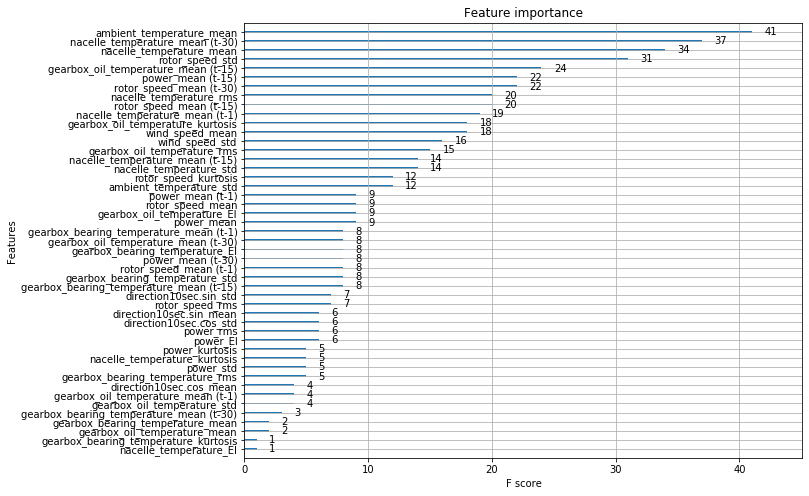

In [486]:
fig, ax = plt.subplots(1,1,figsize=(10,8))
xgb.plot_importance(xgb_model, ax= ax)

In [547]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify = y, test_size=0.1)

xgb_model = xgb.XGBClassifier(objective="binary:logistic", scale_pos_weight=27)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.95      0.97       375
           1       0.32      0.60      0.42        15

    accuracy                           0.94       390
   macro avg       0.65      0.77      0.69       390
weighted avg       0.96      0.94      0.95       390



In [548]:
print(confusion_matrix(y_test, y_pred))

[[356  19]
 [  6   9]]


In [482]:
xgb_model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=27, seed=None,
              silent=None, subsample=1, verbosity=1)

In [550]:
import eli5
from eli5.sklearn import PermutationImportance

from pdpbox import pdp, info_plots

In [551]:
perm = PermutationImportance(xgb_model, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.0138 ± 0.0095,rotor_speed_std
0.0051 ± 0.0086,nacelle_temperature_mean (t-30)
0.0036 ± 0.0052,rotor_speed_kurtosis
0.0036 ± 0.0041,wind_speed_mean
0.0026 ± 0.0032,gearbox_bearing_temperature_mean (t-1)
0.0026 ± 0.0000,power_mean (t-1)
0.0021 ± 0.0094,rotor_speed_mean (t-15)
0.0021 ± 0.0068,power_mean (t-15)
0.0015 ± 0.0025,rotor_speed_mean
0.0015 ± 0.0041,gearbox_oil_temperature_mean (t-1)


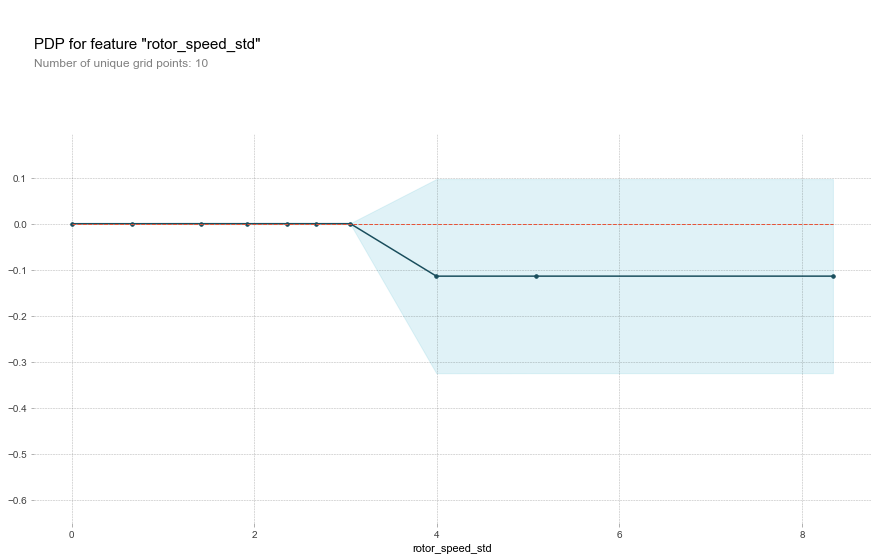

In [552]:
pdp_p = pdp.pdp_isolate(model=xgb_model, dataset=X_test, model_features=X_test.columns.values, feature='rotor_speed_std')
pdp.pdp_plot(pdp_p, 'rotor_speed_std')
plt.show()

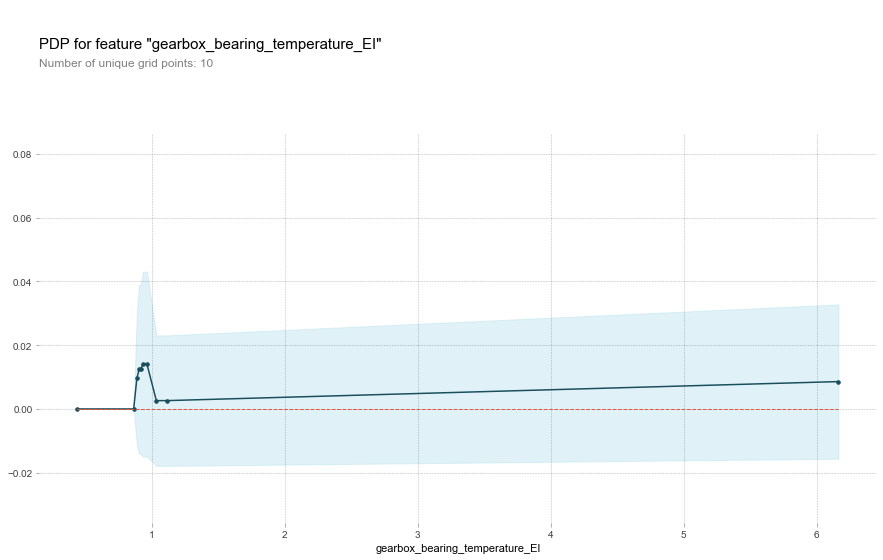

In [555]:
pdp_p = pdp.pdp_isolate(model=xgb_model, dataset=X_test, model_features=X_test.columns.values, feature='gearbox_bearing_temperature_EI')
pdp.pdp_plot(pdp_p, 'gearbox_bearing_temperature_EI')
plt.show()

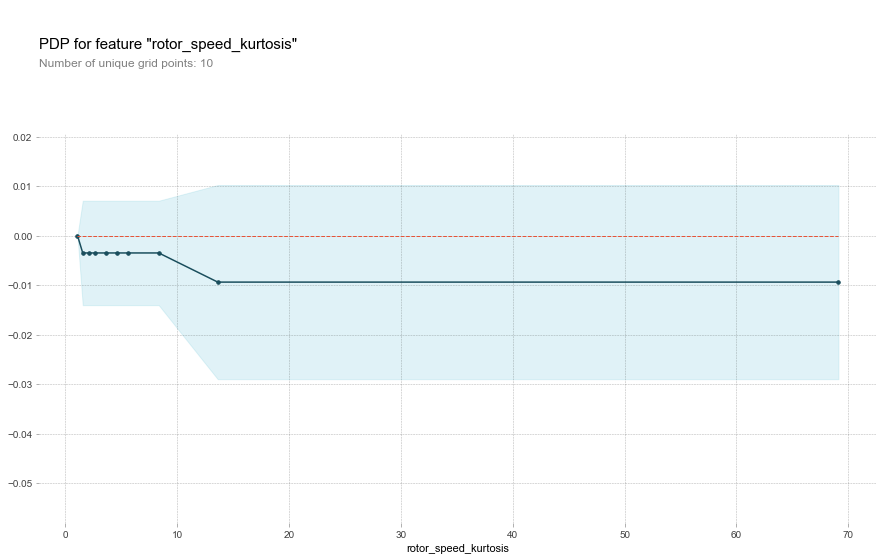

In [556]:
pdp_p = pdp.pdp_isolate(model=xgb_model, dataset=X_test, model_features=X_test.columns.values, feature='rotor_speed_kurtosis')
pdp.pdp_plot(pdp_p, 'rotor_speed_kurtosis')
plt.show()

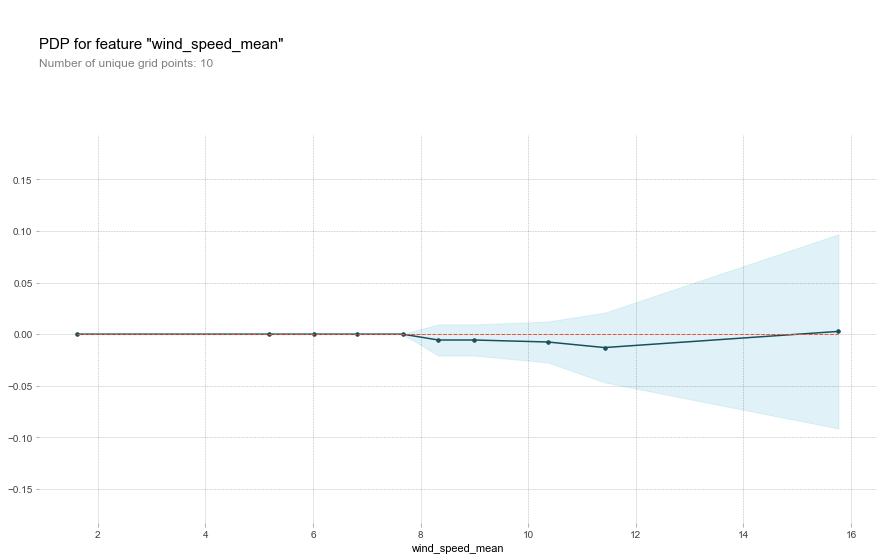

In [557]:
pdp_p = pdp.pdp_isolate(model=xgb_model, dataset=X_test, model_features=X_test.columns.values, feature='wind_speed_mean')
pdp.pdp_plot(pdp_p, 'wind_speed_mean')
plt.show()

### Model Tuning

#### Iteration 1

In [497]:
param_grid = {'min_child_weight':range(1,6,2),
          'max_depth': range(3,10,2),
          'n_estimators':[100],
          'subsample': [1],
          'gamma':[0],
          'reg_alpha':[0],
          'reg_lambda':[1],
          'scale_pos_weight':[27]    
         }


xgb_model = xgb.XGBClassifier(objective="binary:logistic")
grid = GridSearchCV(estimator=xgb_model, param_grid=param_grid, n_jobs=2, cv=5, verbose=1)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    3.0s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    4.1s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    7.2s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    9.2s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:   14.7s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:   19.4s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:   27.5s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   34.5s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:   44.7s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:   46.9s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_l...=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='warn', n_jobs=2,
             param_grid={'gamma': [0], 'max_depth': range(3, 10, 2),
                         'min_child_weight': range(1, 6, 2),
                         'n_estimators': [

In [502]:
grid.best_params_

{'gamma': 0,
 'max_depth': 9,
 'min_child_weight': 1,
 'n_estimators': 100,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 27,
 'subsample': 1}

In [500]:
print(grid.cv_results_['mean_test_score'])

[0.93502422 0.93587917 0.93445426 0.95981761 0.95981761 0.95867769
 0.96551724 0.96323739 0.96124252 0.96637219 0.9615275  0.96266743]


In [501]:
grid.cv_results_['rank_test_score']

array([11, 10, 12,  7,  7,  9,  2,  3,  6,  1,  5,  4], dtype=int32)

In [503]:
param_grid = {'min_child_weight':[1],
          'max_depth': [9],
          'n_estimators':[100, 200, 300, 400, 500],
          'subsample': [0.5, 0.75, 1],
          'gamma':[0],
          'reg_alpha':[0],
          'reg_lambda':[1],
          'scale_pos_weight':[27]    
         }


xgb_model = xgb.XGBClassifier(objective="binary:logistic")
grid = GridSearchCV(estimator=xgb_model, param_grid=param_grid, n_jobs=2, cv=5, verbose=1)
grid.fit(X_train, y_train)

print(grid.best_params_)
print(grid.cv_results_['mean_test_score'])

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  1.5min
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:  3.0min finished


{'gamma': 0, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 400, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 27, 'subsample': 0.75}
[0.96323739 0.96637219 0.96637219 0.96523226 0.96836706 0.96751211
 0.96665717 0.96836706 0.96779709 0.96751211 0.96865204 0.96865204
 0.96523226 0.96836706 0.96836706]


In [504]:
print(grid.cv_results_['rank_test_score'])

[15 11 11 13  3  8 10  3  7  8  1  1 13  3  3]


In [505]:
param_grid = {'min_child_weight':[1],
          'max_depth': [9],
          'n_estimators':[400],
          'subsample': [0.75],
          'gamma':[0, 0.1, 0.2, 0.3, 0.4, 0.5],
          'reg_alpha':[0],
          'reg_lambda':[1],
          'scale_pos_weight':[27]    
         }


xgb_model = xgb.XGBClassifier(objective="binary:logistic")
grid = GridSearchCV(estimator=xgb_model, param_grid=param_grid, n_jobs=2, cv=5, verbose=1)
grid.fit(X_train, y_train)

print(grid.best_params_)
print(grid.cv_results_['mean_test_score'])

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:  1.5min finished


{'gamma': 0, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 400, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 27, 'subsample': 0.75}
[0.96865204 0.96808207 0.96722713 0.96751211 0.9660872  0.96865204]


In [506]:
param_grid = {'min_child_weight':[1],
          'max_depth': [9],
          'n_estimators':[400],
          'subsample': [0.75],
          'gamma':[0],
          'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100],
          'reg_lambda':[1],
          'scale_pos_weight':[27]    
         }

xgb_model = xgb.XGBClassifier(objective="binary:logistic")
grid = GridSearchCV(estimator=xgb_model, param_grid=param_grid, n_jobs=2, cv=5, verbose=1)
grid.fit(X_train, y_train)

print(grid.best_params_)
print(grid.cv_results_['mean_test_score'])

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:  1.1min finished


{'gamma': 0, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 400, 'reg_alpha': 0.1, 'reg_lambda': 1, 'scale_pos_weight': 27, 'subsample': 0.75}
[0.96808207 0.96637219 0.96836706 0.96779709 0.8999715 ]


In [507]:
param_grid = {'min_child_weight':[1],
          'max_depth': [9],
          'n_estimators':[400],
          'subsample': [0.75],
          'gamma':[0],
          'reg_alpha':[0.1],
          'reg_lambda':[1],
          'scale_pos_weight':[16, 18, 20, 22, 24, 26, 28]    
         }

xgb_model = xgb.XGBClassifier(objective="binary:logistic")
grid = GridSearchCV(estimator=xgb_model, param_grid=param_grid, n_jobs=2, cv=5, verbose=1)
grid.fit(X_train, y_train)

print(grid.best_params_)
print(grid.cv_results_['mean_test_score'])

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  35 out of  35 | elapsed:  1.6min finished


{'gamma': 0, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 400, 'reg_alpha': 0.1, 'reg_lambda': 1, 'scale_pos_weight': 26, 'subsample': 0.75}
[0.96893702 0.96808207 0.96779709 0.96808207 0.96779709 0.96950698
 0.96665717]


In [543]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic", min_child_weight=1, max_depth=9, n_estimators=400, subsample=0.75,
                             gamma=0, reg_alpha=0.1, scale_pos_weight=25, base_score=0.5)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       375
           1       0.46      0.40      0.43        15

    accuracy                           0.96       390
   macro avg       0.72      0.69      0.70       390
weighted avg       0.96      0.96      0.96       390



In [544]:
print(confusion_matrix(y_test, y_pred))

[[368   7]
 [  9   6]]


In [545]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic", min_child_weight=1, max_depth=9, n_estimators=400, subsample=0.75,
                             gamma=0, reg_alpha=1, scale_pos_weight=25)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       375
           1       0.43      0.40      0.41        15

    accuracy                           0.96       390
   macro avg       0.70      0.69      0.70       390
weighted avg       0.96      0.96      0.96       390



In [546]:
print(confusion_matrix(y_test, y_pred))

[[367   8]
 [  9   6]]


## Gearbox Bearing Temp Prediction and Residual

In [572]:
X = df_agg_w.drop(['turbine_id', 'Date', 'failure_value', 'gearbox_bearing_temperature_mean (t-30)', 'gearbox_bearing_temperature_mean (t-15)',
                  'gearbox_bearing_temperature_mean (t-1)', 'gearbox_bearing_temperature_mean', 'gearbox_bearing_temperature_EI',
                  'gearbox_bearing_temperature_rms', 'gearbox_bearing_temperature_std'], axis = 1)
y = df_agg_w.gearbox_bearing_temperature_mean

In [574]:
from sklearn import linear_model

lm = linear_model.LinearRegression()
model = lm.fit(X,y)

predictions = lm.predict(X)
print(predictions[0:5])

[50.75876426 33.86150513 53.38773158 46.99446557 57.01849282]


In [575]:
lm.score(X,y)

0.9594522111957724

In [576]:
lm.coef_

array([ 2.33857228e-03, -5.09812657e-04,  1.91517669e-01, -1.08670789e-03,
        7.85389139e-01,  1.81938850e-01,  1.42155836e+00, -7.89764707e-03,
        6.20754380e-01, -2.25164954e-01, -1.87062541e+01, -5.49391063e-04,
        1.42067462e-02,  8.28336769e-02, -1.05608311e-02,  1.86374321e-01,
       -2.48804921e-02, -2.17369064e-02, -2.05241042e-02,  2.48050121e-02,
       -5.48979097e-03,  1.89959573e+00,  4.96567186e-01,  3.04453844e+00,
        2.63990225e-01,  1.89959573e+00,  4.96567186e-01,  3.04453844e+00,
        2.63990225e-01,  9.76687827e-02,  1.93648964e-01,  1.15641764e-04,
       -3.68054774e-02,  9.91782561e-03, -1.30822978e-02, -1.57014514e-04,
        3.80857279e-03,  3.07685095e-03, -4.61363773e-03, -7.86874675e-05,
       -3.76249831e-03,  7.82838538e-03, -1.04864526e-02,  4.97538466e+00,
        9.16412800e+01, -5.74236844e-01])

In [577]:
lm.intercept_

5.377522337941656

In [578]:
residuals = predictions - y
residuals[0:5]

30   -1.574191
31    0.968105
32   -0.155619
33   -1.239423
34    0.087155
Name: gearbox_bearing_temperature_mean, dtype: float64

In [585]:
res_df = pd.DataFrame({'turbine_id': df_agg_w.turbine_id, 'residual':residuals}, columns=['turbine_id', 'residual'])
res_df = res_df.reset_index(drop = True)
res_df.head()

,turbine_id,residual
0,2,-1.574191
1,2,0.968105
2,2,-0.155619
3,2,-1.239423
4,2,0.087155


turbine_id
2     AxesSubplot(0.125,0.125;0.775x0.755)
29    AxesSubplot(0.125,0.125;0.775x0.755)
65    AxesSubplot(0.125,0.125;0.775x0.755)
70    AxesSubplot(0.125,0.125;0.775x0.755)
84    AxesSubplot(0.125,0.125;0.775x0.755)
Name: residual, dtype: object

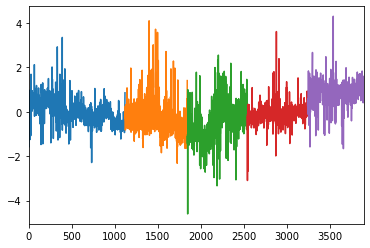

In [589]:
res_df.groupby('turbine_id')['residual'].plot(kind='line')

In [ ]:
fig, ax = plt.subplots(figsize=(10,4))
for key, grp in res_df.groupby(['turbine_id']):
    ax.plot(grp['Date'], grp['adj_close'], label=key)

ax.legend()
plt.show()

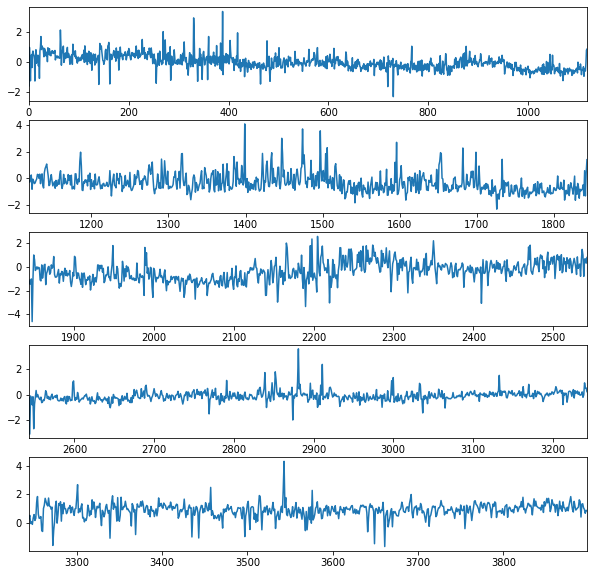

In [598]:
fig, ax = plt.subplots(figsize=(10,10), nrows=5, ncols=1)
i =0 
for key, grp in res_df.groupby(['turbine_id']):
    grp['residual'].plot(kind='line', ax=ax[i])
    i = i+1

## Xgboost Regressor

In [600]:
df_agg_w.head()

,turbine_id,Date,power_mean,power_std,power_rms,power_kurtosis,rotor_speed_mean,rotor_speed_std,rotor_speed_rms,rotor_speed_kurtosis,...,nacelle_temperature_mean (t-15),power_mean (t-30),rotor_speed_mean (t-30),gearbox_bearing_temperature_mean (t-30),gearbox_oil_temperature_mean (t-30),nacelle_temperature_mean (t-30),power_EI,gearbox_bearing_temperature_EI,gearbox_oil_temperature_EI,nacelle_temperature_EI
30,2,2008-12-31,682.790300,668.264968,201.413376,1.254915,9.919606,9.222386,2.857088,1.040994,...,-1.136523,63.723599,-5.801559,-5.317696,-3.207241,-1.713446,2.984135,2.025173,2.091830,99.949963
31,2,2009-01-01,-1.962200,1.458646,0.485501,9.974295,0.176680,0.071173,0.037989,4.835816,...,-4.742095,-632.792012,-16.231858,-26.066788,-13.630849,-14.617927,0.007193,1.175029,1.490776,0.240926
32,2,2009-01-02,513.366028,489.932043,73.007180,1.821188,11.282246,8.050484,1.426981,1.463668,...,3.266422,-970.728813,-6.881627,-6.195855,-2.281641,4.538171,1.081672,1.004287,1.022233,36.229296
33,2,2009-01-03,57.036833,78.258674,17.486636,1.870200,4.850500,5.740028,1.358639,1.199283,...,0.125572,-480.452173,-10.741827,-9.852931,-5.314653,10.293777,0.259081,1.594740,1.758372,8.677619
34,2,2009-01-04,1332.568842,465.968070,173.623424,7.376695,16.441940,5.622116,2.137212,7.564648,...,-6.808222,1094.177176,6.815510,7.417180,2.459568,-3.770868,2.572400,1.263227,1.261701,86.159396


In [601]:
df_agg_w.shape

(3899, 56)

In [602]:
df_agg_w.failure_value.value_counts()

0    3746
1     153
Name: failure_value, dtype: int64

In [606]:
df_agg_w.turbine_id.unique()

array([ 2, 29, 65, 70, 84])

In [609]:
df = df_agg_w[df_agg_w.turbine_id != 84]
X = df.drop(['turbine_id', 'failure_value', 'month.cos_value', 'month.sin_value', 'Date'], axis =1)
y = df.failure_value

In [611]:
xgb_model = xgb.XGBRegressor()
xgb_model

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [612]:
xgb_model.fit(X, y, verbose=10)

[09:51:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [613]:
xgb_model.score(X, y)

0.5906633585057861

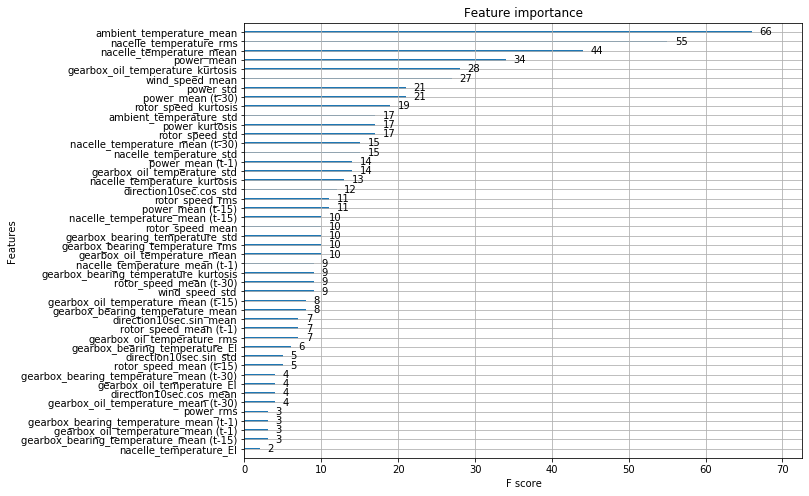

In [615]:
fig, ax = plt.subplots(1,1,figsize=(10,8))
xgb.plot_importance(xgb_model, ax=ax)

In [617]:
df_test = df_agg_w[df_agg_w.turbine_id == 84]
X_test = df_test.drop(['turbine_id', 'failure_value', 'month.cos_value', 'month.sin_value', 'Date'], axis =1)
y_test = df_test.failure_value

predictions = xgb_model.predict(X_test)

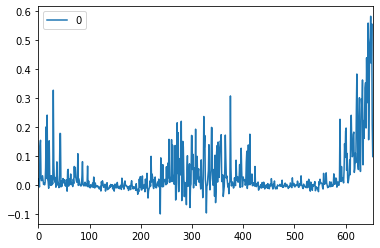

In [621]:
pd.DataFrame(predictions).plot(kind='line')

In [623]:
pred_df = pd.DataFrame(predictions, columns=['pred_probs'])
pred_df['MA'] = pred_df.rolling(window=5).mean()
pred_df.head()

,pred_probs,MA
0,0.020819,NaN
1,0.014391,NaN
2,-0.006448,NaN
3,0.133732,NaN
4,0.154187,0.063337


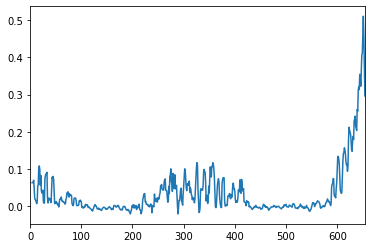

In [624]:
pred_df.MA.plot(kind = 'line')

In [625]:
perm = PermutationImportance(xgb_model, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.3221 ± 0.0599,nacelle_temperature_mean
0.1810 ± 0.0164,ambient_temperature_mean
0.0710 ± 0.0228,rotor_speed_std
0.0568 ± 0.0195,nacelle_temperature_rms
0.0368 ± 0.0082,power_mean
0.0319 ± 0.0120,wind_speed_mean
0.0300 ± 0.0206,rotor_speed_mean (t-30)
0.0289 ± 0.0097,gearbox_oil_temperature_kurtosis
0.0286 ± 0.0108,nacelle_temperature_kurtosis
0.0217 ± 0.0058,rotor_speed_mean (t-1)


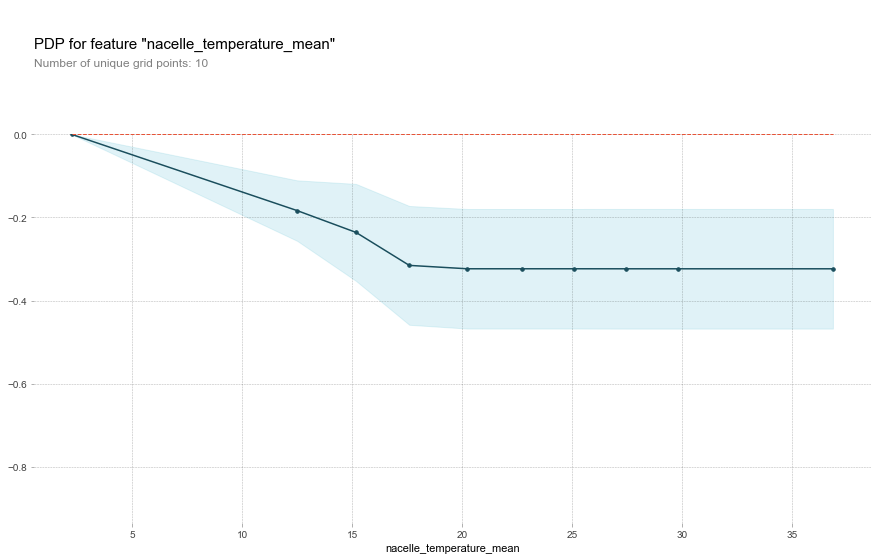

In [626]:
pdp_p = pdp.pdp_isolate(model=xgb_model, dataset=X_test, model_features=X_test.columns.values, feature='nacelle_temperature_mean')
pdp.pdp_plot(pdp_p, 'nacelle_temperature_mean')
plt.show()

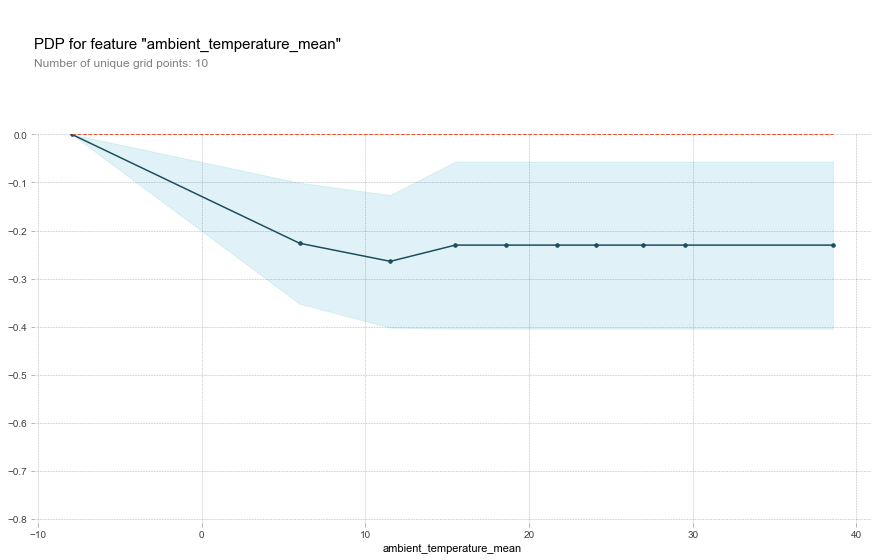

In [627]:
pdp_p = pdp.pdp_isolate(model=xgb_model, dataset=X_test, model_features=X_test.columns.values, feature='ambient_temperature_mean')
pdp.pdp_plot(pdp_p, 'ambient_temperature_mean')
plt.show()

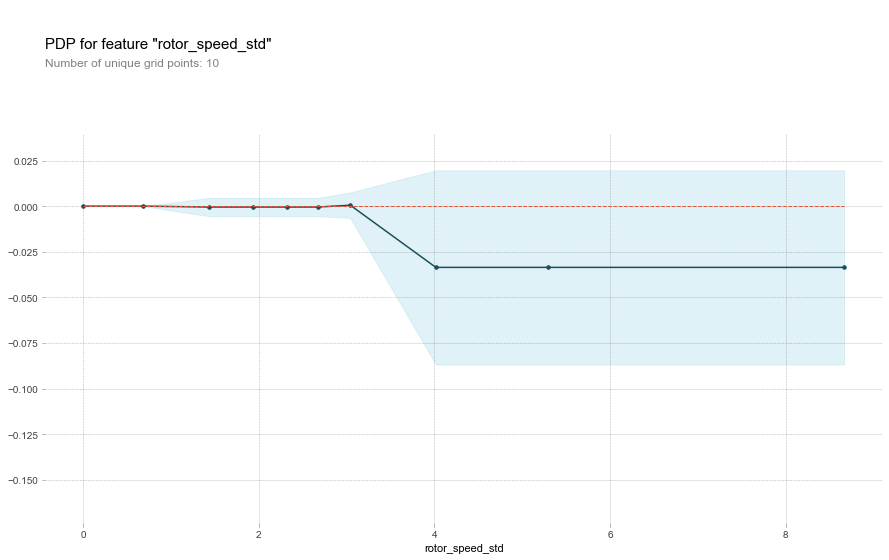

In [628]:
pdp_p = pdp.pdp_isolate(model=xgb_model, dataset=X_test, model_features=X_test.columns.values, feature='rotor_speed_std')
pdp.pdp_plot(pdp_p, 'rotor_speed_std')
plt.show()

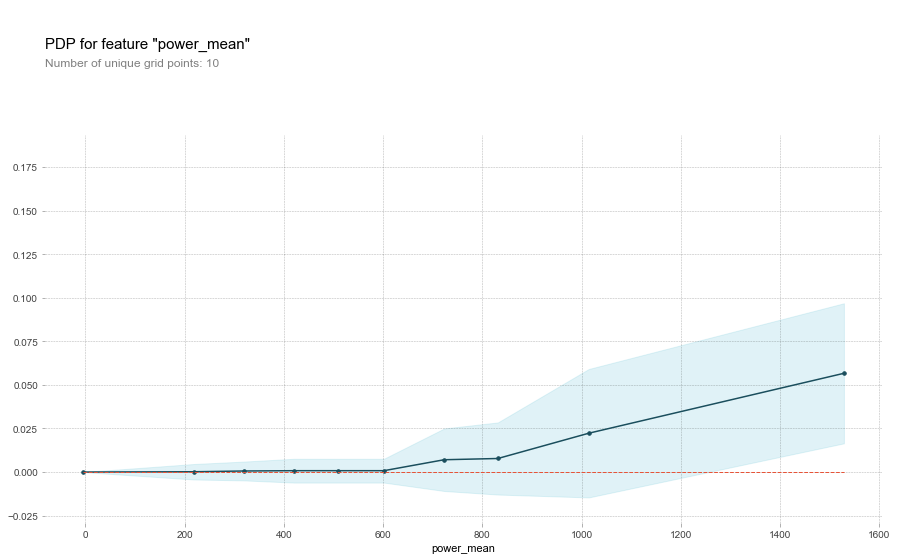

In [629]:
pdp_p = pdp.pdp_isolate(model=xgb_model, dataset=X_test, model_features=X_test.columns.values, feature='power_mean')
pdp.pdp_plot(pdp_p, 'power_mean')
plt.show()

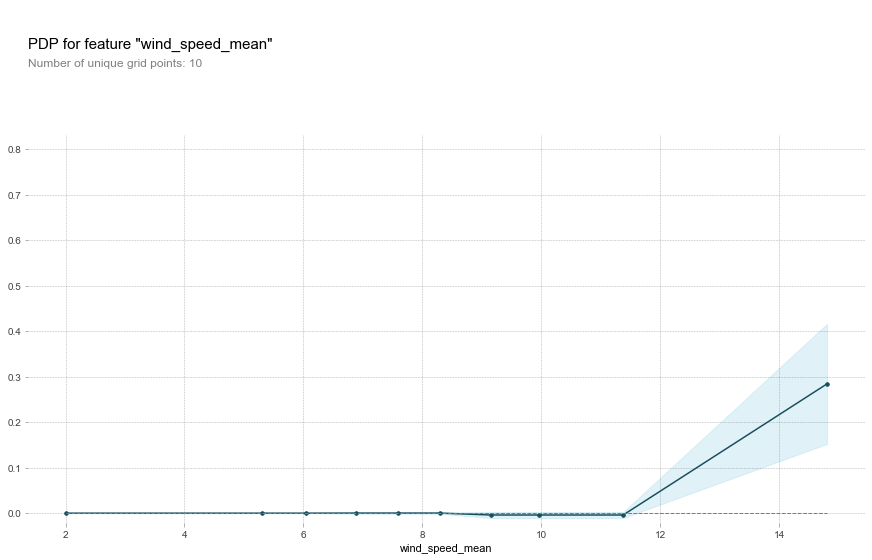

In [630]:
pdp_p = pdp.pdp_isolate(model=xgb_model, dataset=X_test, model_features=X_test.columns.values, feature='wind_speed_mean')
pdp.pdp_plot(pdp_p, 'wind_speed_mean')
plt.show()

In [640]:
### test on healthy turbine